In [4]:
# Setup plot defaultrialsrialsrialss
import matplotlib.pyplot as plt
import seaborn as sns

# Reset styling to default
plt.rcdefaults()
# Grid on
plt.rcParams['axes.grid'] = True
# Top and right axis spines off
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Title 18 x y labels 16 ticks 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig_w=6
fig_h=6
plt.rcParams['figure.figsize'] = (fig_w,fig_h )
# Make axis equal
#plt.rcParams['axes.axisbelow'] = True 


plt.rcParams['grid.color'] = '0.8'# Grid color

# Set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#043908', '#ff7f0e', '#9467bd', '#d62728', '#364704', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
# Set default grid settings
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.family'] = 'sans-serif'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70

In [5]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt


In [44]:
# Psychometric function
def psychometric_function(intensities, lapse_rate, mu, sigma):
    # Cumulative distribution function with mean mu and standard deviation sigma
    cdf = norm.cdf(intensities, loc=mu, scale=sigma) 
    # take into account of lapse rate and return the probability of choosing test
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf 

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params # Unpack parameters
    p = psychometric_function(delta_dur, lambda_, mu, sigma) # Compute probability of choosing test
    epsilon = 1e-9 # Add a small number to avoid log(0) when calculating the log-likelihood
    p = np.clip(p, epsilon, 1 - epsilon) # Clip p to avoid log(0) and log(1)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fit_psychometric_function(data_grouped,init_guesses=[0, -0.2, 0.05]):
    # takes the grouped data mainly takes the following columns
    intensities=data_grouped['delta_dur_percents'].values
    chose_test=data_grouped['num_of_chose_test'].values
    total_resp=data_grouped['total_responses'].values
    # then fits the psychometric function
    initial_guess =init_guesses   # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.2), (-1, 1), (-1, 1)]  # Reasonable bounds
    # fitting is done here
    result = minimize(
        negative_log_likelihood, initial_guess, 
        args=(intensities, chose_test, total_resp),
        bounds=bounds,
        method='Nelder-Mead'
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x

# Fit psychometric function for raw data
def fit_raw_psychometric(X):
    initial_guess = [0, -.2, 0.05] # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.06), (-inf, +inf), (0.01, 0.2)]  # Reasonable bounds
    
    intensities = X['delta_dur_percents'].values
    chose_test = X['chose_test'].values
    total_resp = np.ones_like(chose_test)  # Each trial is a single observation
    result = minimize(negative_log_likelihood, initial_guess, 
                      args=(intensities, chose_test, total_resp), 
                      bounds=bounds)
    lambda_hat, mu_hat, sigma_hat = result.x
    return lambda_hat, mu_hat, sigma_hat


In [45]:
# Load data
file_path = 'data/'+'_auditory_dur_estimate_2025-01-08_16h34.13.197.csv'
#_auditory_dur_estimate_2025-01-08_16h34.13.197.csv'
#_auditory_dur_estimate_2024-12-19_01h06.07.475.csv'
data = pd.read_csv(file_path)
data['chose_test'] = (data['responses'] == data['order']).astype(int)

grouped = data.groupby(['delta_dur_percents', 'rise_dur', 'standard_dur']).agg(
    num_of_chose_test=('chose_test', 'sum'),
    total_responses=('responses', 'count'),
).reset_index()

# p_choose_test
grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']
#sort the group
grouped = grouped.sort_values([ 'standard_dur'])
grouped

,delta_dur_percents,rise_dur,standard_dur,num_of_chose_test,total_responses,p_choose_test
15,-0.1625,0.050,1.00,0,1,0.0
46,0.3500,0.245,1.00,0,1,0.0
19,-0.1000,0.050,1.00,1,1,1.0
17,-0.1250,0.050,1.00,0,1,0.0
50,0.4250,0.245,1.00,1,1,1.0
...,...,...,...,...,...,...
37,0.1625,0.245,1.75,0,1,0.0
70,0.8000,0.050,1.75,1,1,1.0
29,-0.0125,0.245,1.75,0,1,0.0
8,-0.2750,0.245,1.75,0,1,0.0


In [46]:
# linear regression 
# pseude inverse using SVD
def pseudo_inverse(X):
    U, S, VT = np.linalg.svd(X)
    S_inv = np.zeros((X.shape[1], X.shape[0]))
    for i in range(S.shape[0]):
        S_inv[i,i] = 1/S[i]
    return VT.T @ S_inv @ U.T

# Function to compute B_opt using SVD for a given order
def compute_B_opt(x, y, order):
    # Assuming x and y are already defined and reshaped
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Extend the design matrix X for the given order
    X = np.hstack([x**i for i in range(order + 1)])
    # Perform SVD
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    
    # Compute y_prime
    y_prime = U.T @ y
    
    # Compute the pseudoinverse of S
    S_inv = pseudo_inverse(np.diag(S))
    
    # Compute B_opt_prime
    B_opt_prime = S_inv @ y_prime
    
    # Compute B_opt
    B_opt = Vt.T @ B_opt_prime
    
    return B_opt



/var/folders/_p/yywkspd92qs_6p63bz38bswr0000gn/T/ipykernel_88460/3250284434.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  init_sigma=float(m)


Standard: 1.75, Rise: 0.05
Standard: 1.75, Rise: 0.245
Standard: 1.5, Rise: 0.05
Standard: 1.5, Rise: 0.245
Standard: 1.0, Rise: 0.05
Standard: 1.0, Rise: 0.245
Standard: 1.25, Rise: 0.05
Standard: 1.25, Rise: 0.245


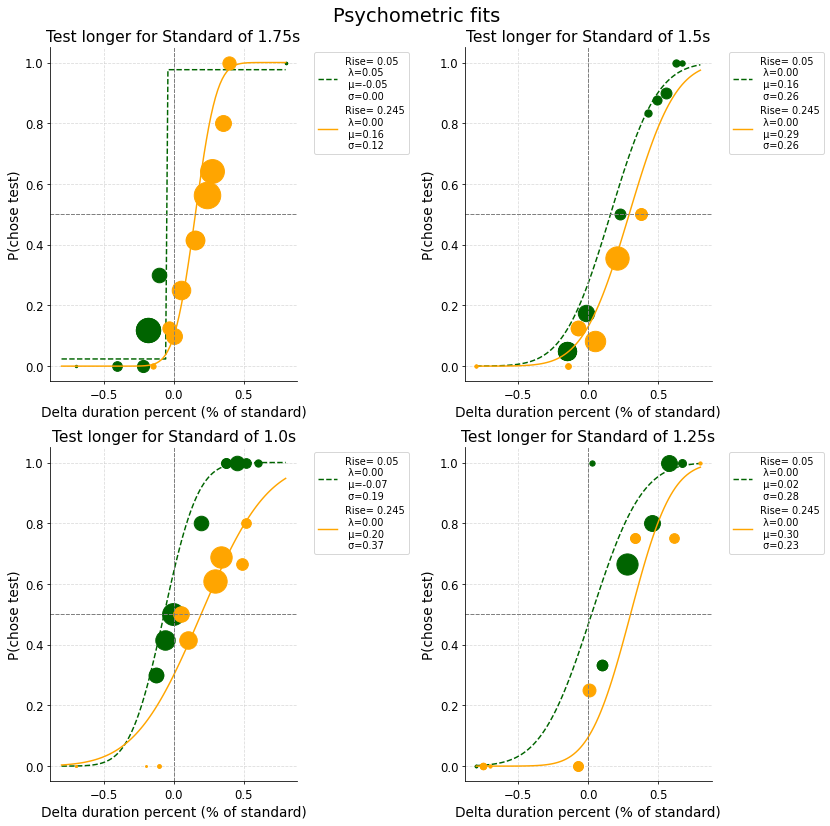

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
#overall figure title
fig.suptitle('Psychometric fits', fontsize=20)
for idx_stand, standard_ in enumerate(data['standard_dur'].unique()):
    for idx_rise, rise_dur_ in enumerate(data['rise_dur'].unique()):
        X = grouped[
            (grouped['standard_dur'] == standard_) & 
            (grouped['rise_dur'] == rise_dur_)
        ]
        # sort X based on delta_dur_percents
        X = X.sort_values('standard_dur') 
        lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(X) # Fit psychometric function
        x_fit = np.linspace(min(data['delta_dur_percents']), max(data['delta_dur_percents']), 100)
        y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
        #linear fit
        B_opt=compute_B_opt(x_fit,y_fit,1) # returns mx+n function m (slope) and n (scalar) values
        [n,m]=B_opt
        linear_y_fit = [(m*i+n) for i in x_fit]#np.sum(B_opt[j] * x_fit**j for j in range(2))
        # if we fit a straight line (lin reg) to the psycometric func the point where it goes through 50% is a good initial guess for mu
        # and slope of regression is a decent guess(likely underestimate) which can be translated to sigma.
        # lapse rate 3 or 5 perccent is fine
        init_sigma=float(m)
        init_mu= x_fit[round(np.mean((np.where(np.round(linear_y_fit,1)==0.5))[0]))]
        init_lapse=0.03
        init_guesses=[init_lapse,init_mu,init_sigma]
        #print(init_guesses)
        lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(X,init_guesses=init_guesses) # Fit psychometric function


        print(f'Standard: {standard_}, Rise: {rise_dur_}') # Print standard and rise duration
        lineStyle = '--' if rise_dur_ == 0.050 else '-'  # Different line style for rise_dur=0.050
        lineColor = 'darkgreen' if rise_dur_ == 0.050 else 'orange'  # Different line color for rise_dur=0.050

        x_data = X['delta_dur_percents']
        y_data = X['p_choose_test']
 
        ax = axs[idx_stand // 2, idx_stand % 2]

        bin_size=10
        bin_distance=0.3
        x_data=X['delta_dur_percents']
        y_data=X['p_choose_test']
        total_bins=X['total_responses']
        for m in np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),bin_size):
                # search for values +- 0.2 of the i value
                mask=(x_data>=m-bin_distance) & (x_data<m+bin_distance)
                # get the mean of the values
                x_mean=np.mean(x_data[mask])
                y_mean=np.mean(y_data[mask])
                # get the total responses
                total_resp=np.sum(total_bins[mask])
                # plot the mean values
                ax.plot(x_mean,y_mean,'o',markersize=total_resp/np.sum(total_bins)*30,color=lineColor)
        
        x_fit = np.linspace(min(data['delta_dur_percents']), max(data['delta_dur_percents']), 100)
        y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
        ax.plot(x_fit, y_fit, linestyle=lineStyle, color=lineColor, label=f'Rise= {rise_dur_}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}')
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
        ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
        ax.set_xlabel('Delta duration percent (% of standard)')
        ax.set_ylabel('P(chose test)')
        ax.set_title(f'Test longer for Standard of {standard_}s')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # remove axspines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
# Psychometric fit results when the data is not pooled at all and fitted on each rise duration and standard duration


for the standard of 1.0 and rise duration of0.05 λ: 0.000, μ: -0.068, σ: 0.191
for the standard of 1.0 and rise duration of0.245 λ: 0.000, μ: 0.196, σ: 0.372
for the standard of 1.25 and rise duration of0.05 λ: 0.000, μ: 0.023, σ: 0.283
for the standard of 1.25 and rise duration of0.245 λ: 0.000, μ: 0.301, σ: 0.231
for the standard of 1.5 and rise duration of0.05 λ: 0.000, μ: 0.158, σ: 0.264
for the standard of 1.5 and rise duration of0.245 λ: 0.000, μ: 0.291, σ: 0.260
for the standard of 1.75 and rise duration of0.05 λ: 0.000, μ: -0.052, σ: 0.007
for the standard of 1.75 and rise duration of0.245 λ: 0.000, μ: 0.155, σ: 0.120


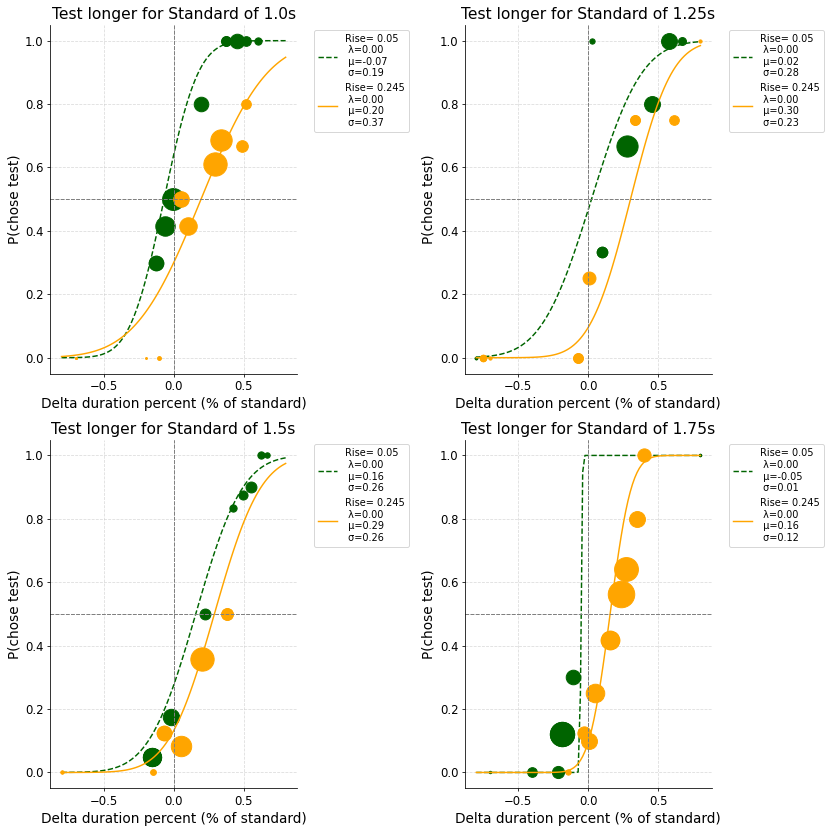

In [49]:

def plot_psychometric_functions(data):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    #sort the data by standard duration
    data = data.sort_values(by='standard_dur')
    # fildering loop for each standard duration
    for k, i in enumerate(data['standard_dur'].unique()):
        # Filter data by standard duration
        data_by_standard = data[data['standard_dur'] == i].copy()
        # take the choose test column if  response is equal to test order
        data_by_standard.loc[:, 'chose_test'] = (data_by_standard['responses'] == data_by_standard['order']).astype(int)

        # Group data by delta_dur_percents and rise_dur
        aggregated_data = data_by_standard.groupby(['delta_dur_percents', 'rise_dur']).agg(
                num_of_chose_test=('chose_test', 'sum'),
                total_responses=('responses', 'count'),
        ).reset_index()
        # Calculate the probability of choosing the test
        aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']
        # sort the values
        aggregated_data = aggregated_data.sort_values(by='rise_dur')
        # select each rise_dur and fit the psychometric function
        for j in aggregated_data['rise_dur'].unique():
            lineStyle = '--' if j == 0.050 else '-'  # Different line style for rise_dur=0.050
            lineColor = 'darkgreen' if j == 0.050 else 'orange'  # Different line color for rise_dur=0.050

            # Filter the data by rise_dur
            Y = aggregated_data[aggregated_data['rise_dur'] == j]
            lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(Y)
            
            print(f"for the standard of {i} and rise duration of{j} λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

            x_data = Y['delta_dur_percents']
            y_data = Y['p_choose_test']
                        
            # # Normalize bin sizes for scatter plot
            ax = axs[k // 2, k % 2]
            X=Y
            X=X.sort_values(by='delta_dur_percents')
            bin_size=10
            bin_distance=0.3
            x_data=X['delta_dur_percents']
            y_data=X['p_choose_test']
            total_bins=X['total_responses']
            for m in np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),bin_size):
                    # search for values +- 0.2 of the i value
                    mask=(x_data>=m-bin_distance) & (x_data<m+bin_distance)
                    # get the mean of the values
                    x_mean=np.mean(x_data[mask])
                    y_mean=np.mean(y_data[mask])
                    # get the total responses
                    total_resp=np.sum(total_bins[mask])
                    # plot the mean values
                    ax.plot(x_mean,y_mean,'o',markersize=total_resp/np.sum(total_bins)*30,color=lineColor)
                    
            x_fit = np.linspace(min(data['delta_dur_percents']), max(data['delta_dur_percents']), 100)
            y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
            ax.plot(x_fit, y_fit, linestyle=lineStyle, color=lineColor, label=f'Rise= {j}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}')
            ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
            ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
            ax.set_xlabel('Delta duration percent (% of standard)')
            ax.set_ylabel('P(chose test)')
            ax.set_title(f'Test longer for Standard of {i}s')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            # remove axspines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Call the function
plot_psychometric_functions(data)

# Pool data across standard durations

,delta_dur_percents,rise_dur,num_of_chose_test,total_responses,p_choose_test
0,-0.8,0.245,0,2,0.0
1,-0.7,0.245,0,2,0.0


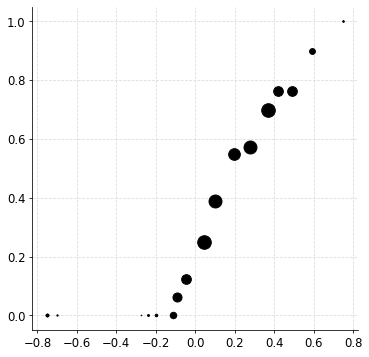

In [115]:
data_by_rise.loc[:, 'chose_test'] = (data_by_rise['responses'] == data_by_rise['order']).astype(int)


aggregated_data = data_by_rise.groupby(['delta_dur_percents', 'rise_dur']).agg(
                num_of_chose_test=('chose_test', 'sum'),
                total_responses=('responses', 'count'),
        ).reset_index()
aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']

# sort the values
aggregated_data = aggregated_data.sort_values(by='rise_dur')
lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(aggregated_data)

X=aggregated_data
x_bins=np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']))
X=X.sort_values(by='delta_dur_percents')
bin_size=5
x_data=X['delta_dur_percents']
y_data=X['p_choose_test']
total_bins=X['total_responses']

#for idx_data, delta in enumerate(X['delta_dur_percents']):

for i in np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),20):
    # search for values +- 0.2 of the i value
    mask=(x_data>=i-0.2) & (x_data<i+0.2)
    # get the mean of the values
    x_mean=np.mean(x_data[mask])
    y_mean=np.mean(y_data[mask])
    # get the total responses
    total_resp=np.sum(total_bins[mask])
    # plot the mean values
    plt.plot(x_mean,y_mean,'o',markersize=total_resp/np.sum(total_bins)*30,color='k')
    #plt.plot(x_mean,y_mean,'o',markersize=total_resp/np.sum(total_bins)*10,color='k')

# for i in range(len(x_data)):
#     plt.plot(np.mean(x_data[i-bin_size:i+bin_size]),np.mean(y_data[i:i+bin_size]),'o', 
#              markersize=np.sum(total_bins[i:i+bin_size])/np.sum(total_bins)*30,color='k')
    

X[:2]


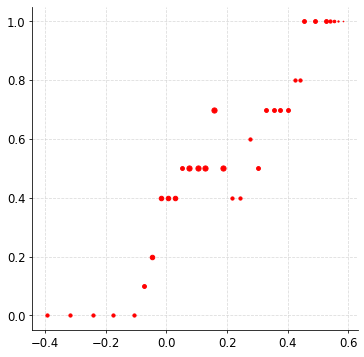

In [116]:
def plot_binned_data(X,bin_size=5,color='k'):# X should be grouped data
    X=X.sort_values(by='delta_dur_percents')
    x_data=X['delta_dur_percents']
    y_data=X['p_choose_test']
    total_bins=X['total_responses']
    x_bins=np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),15)
    for i in range(len(x_data)):
        plt.plot(np.mean(x_data[i-bin_size:i+bin_size]),np.mean(y_data[i:i+bin_size]),'o', 
                markersize=np.sum(total_bins[i:i+bin_size])/np.sum(total_bins)*30,color=color)

data = data.sort_values(by='standard_dur')
data_by_rise = data[data['rise_dur'] == 0.245].copy()
data_by_rise=data_by_rise.sort_values(by='rise_dur')    
aggregated_data = data_by_rise.groupby(['delta_dur_percents', 'standard_dur']).agg(
                num_of_chose_test=('chose_test', 'sum'),
                total_responses=('responses', 'count'),
        ).reset_index()
aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']

plot_binned_data(aggregated_data,bin_size=5,color='r')


# Functions to pool data across standard durations

In [134]:
def data_grouped_standard(data,rise_cond,standard_dur):
    """  
    This function groups the data by standard duration and rise condition
    """
    data = data.sort_values(by='standard_dur') # sort the data by standard duration
    data_by_rise = data[data['rise_dur'] == rise_cond].copy() # filter the data by rise condition
    
    # group the data by delta duration and standard duration
    aggregated_data = data_by_rise.groupby(['delta_dur_percents', 'standard_dur']).agg(
                    num_of_chose_test=('chose_test', 'sum'),
                    total_responses=('responses', 'count'),
            ).reset_index()
    # calculate the probability of choosing test
    aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']

    # sort the values
    aggregated_data = aggregated_data.sort_values(by='standard_dur')

    # filter the data by standard duration
    aggregated_data = aggregated_data[aggregated_data['standard_dur'] == standard_dur].copy()
    
    return aggregated_data

a=data_grouped_standard(data,0.05,1)
a[:2]

,delta_dur_percents,standard_dur,num_of_chose_test,total_responses,p_choose_test
8,-0.1625,1.0,0,1,0.0
19,0.2750,1.0,2,2,1.0


λ: 0.000, μ: 0.229, σ: 0.246
λ: 0.000, μ: 0.229, σ: 0.246
λ: 0.000, μ: 0.229, σ: 0.246
λ: 0.000, μ: 0.229, σ: 0.246
λ: 0.000, μ: 0.036, σ: 0.238
λ: 0.000, μ: 0.036, σ: 0.238
λ: 0.000, μ: 0.036, σ: 0.238
λ: 0.000, μ: 0.036, σ: 0.238


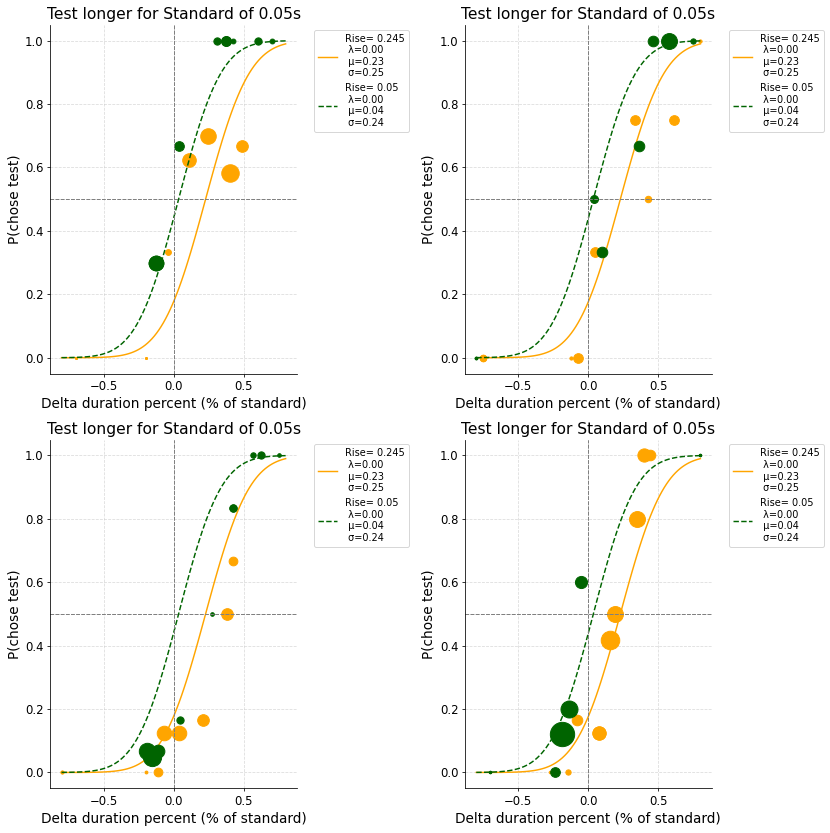

In [ ]:
# plot seperate psychometric functions for each rise condition and standard duration
def plot_psychometric_functions(data):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    #sort the data by standard duration
    data = data.sort_values(by='standard_dur')
    
    for k, i in enumerate(data['rise_dur'].unique()):
        # Filter data by standard duration
        data_by_rise = data[data['rise_dur'] == i].copy()
        # take the choose test column if  response is equal to test order
        data_by_rise.loc[:, 'chose_test'] = (data_by_rise['responses'] == data_by_rise['order']).astype(int)


        aggregated_data = data_by_rise.groupby(['delta_dur_percents', 'standard_dur']).agg(
                num_of_chose_test=('chose_test', 'sum'),
                total_responses=('responses', 'count'),
        ).reset_index()
        aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']

        # sort the values
        aggregated_data = aggregated_data.sort_values(by='standard_dur')
        lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(aggregated_data)

        for idx_data, j in enumerate(aggregated_data['standard_dur'].unique()):
            lineStyle = '--' if i == 0.050 else '-'  # Different line style for rise_dur=0.050
            lineColor = 'darkgreen' if i == 0.050 else 'orange'  # Different line color for rise_dur=0.050

            Y = aggregated_data[aggregated_data['standard_dur'] == j]
            print(f"λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

            x_data = Y['delta_dur_percents']
            y_data = Y['p_choose_test']
            

            ax = axs[idx_data // 2, idx_data % 2]
            # ax.scatter(bin_centers, y_data_smooth_binned, s=bin_sizes_normalized, alpha=0.3)

            #ax.scatter(bin_centers, y_data_smooth_binned, alpha=0.3)
            X=data_grouped_standard(data,i,j)
            X=X.sort_values(by='delta_dur_percents')
            bin_size=3
            x_data=X['delta_dur_percents']
            y_data=X['p_choose_test']
            total_bins=X['total_responses']

            for m in np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),10):
                # search for values +- 0.2 of the i value
                mask=(x_data>=m-0.2) & (x_data<m+0.2)
                # get the mean of the values
                x_mean=np.mean(x_data[mask])
                y_mean=np.mean(y_data[mask])
                # get the total responses
                total_resp=np.sum(total_bins[mask])
                # plot the mean values
                ax.plot(x_mean,y_mean,'o',markersize=total_resp/np.sum(total_bins)*30,color=lineColor)
                
            #ax.scatter(x_data,y_data)
            x_fit = np.linspace(min(data['delta_dur_percents']), max(data['delta_dur_percents']), 100)
            y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
            ax.plot(x_fit, y_fit, linestyle=lineStyle, color=lineColor, label=f'Rise= {i}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}')
            ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
            ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
            ax.set_xlabel('Delta duration percent (% of standard)')
            ax.set_ylabel('P(chose test)')
            ax.set_title(f'Test longer for Standard of {i}s')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            # remove axspines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Call the function
plot_psychometric_functions(data)

## Bootstrap

In [119]:
# Fit the psychometric function to the original data
lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(grouped)

# Original parameter values
print(f"Original Fit: λ = {lambda_hat}, μ = {mu_hat}, σ = {sigma_hat}")



Original Fit: λ = 0.0, μ = 0.1379151251789255, σ = 0.28801594024987476


#### 2. Simulating Bootstrap Data python Copy code

In [120]:
"""Code explanation:
After simply fitting raw data I generated a parametric bootstrap dataset and fitted the psychometric function to the bootstrap dataset.
I repeated this process 1000 times and stored the fitted parameters in a list.

## Algorithm for bootstrapping

1. Filter data based on specific “rise duration” and “standard duration”
2. Fit filtered data
3. Compute probablity ‘p’ of “chosing test” for each intensity using psychometric function and retrieved fitting parameters
4. Create a resampled data using binomial draws on probablity p with n_trials 
5. Re-fit the psychometric function with resampled data to get bootstrapped parameter fits
6. Repeat for desired number of bootstraps


"""

# Generate a single parametric bootstrap dataset
def generate_parametric_bootstrap(original_data):
    simulated_data = original_data.copy()
    lambda_, mu_, sigma_ = fit_psychometric_function(original_data)

    for idx, row in simulated_data.iterrows():
        x = row['delta_dur_percents']
        n_trials = row['total_responses']
        
        # Compute the probability of "chose test" using the psychometric function
        p = psychometric_function(x, lambda_, mu_, sigma_)
        
        # Simulate responses as binomial random draws
        simulated_responses = np.random.binomial(n=n_trials, p=p)
        simulated_data.at[idx, 'num_of_chose_test'] = simulated_responses
    
    return simulated_data


#### 3. Bootstrapping the fit

In [121]:

def full_bootstraping(data, n_bootstrap):
    bootstrap_fits = []
    bootstraps=[]
    for _ in range(n_bootstrap):
        # Generate a bootstrap dataset
        bootstrap_data = generate_parametric_bootstrap(data)
        bootstraps.append(bootstrap_data)
        # Re-fit the psychometric function to the bootstrap data
        lambda_, mu_, sigma_ = fit_psychometric_function(bootstrap_data)        

        bootstrap_fits.append([lambda_, mu_, sigma_])
    bootstrap_fits = pd.DataFrame(bootstrap_fits, columns=['lambda', 'mu', 'sigma'])
    bootstraps = pd.concat(bootstraps)
    bootstraps["p_choose_test"] = bootstraps["num_of_chose_test"] / bootstraps["total_responses"]
    return bootstrap_fits, bootstraps

bootstrap_fits, bootstraps = full_bootstraping(grouped, 100)

#### 4. Analyzing Bootstrap Results


λ 95% CI: [0.   0.06]
μ 95% CI: [0.04516013 0.22247968]
σ 95% CI: [0.16955188 0.40691902]


Text(0.5, 1.0, 'σ')

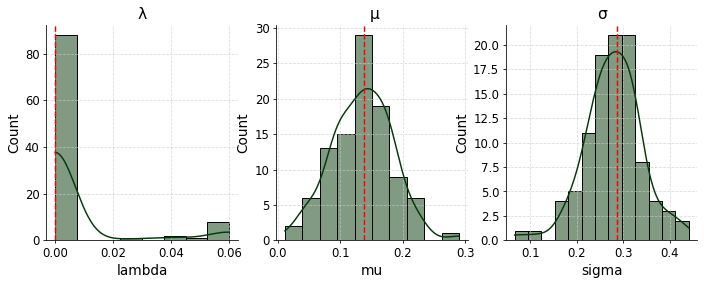

In [122]:
# Calculate 95% confidence intervals for each parameter
lambda_ci = np.percentile(bootstrap_fits['lambda'], [2.5, 97.5])
mu_ci = np.percentile(bootstrap_fits['mu'], [2.5, 97.5])
sigma_ci = np.percentile(bootstrap_fits['sigma'], [2.5, 97.5])

print(f"λ 95% CI: {lambda_ci}")
print(f"μ 95% CI: {mu_ci}")
print(f"σ 95% CI: {sigma_ci}")

# Plot the bootstrap distributions
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(bootstrap_fits['lambda'], kde=True)
plt.axvline(lambda_hat, color='red', linestyle='--')
plt.title('λ')

plt.subplot(1, 3, 2)
sns.histplot(bootstrap_fits['mu'], kde=True)
plt.axvline(mu_hat, color='red', linestyle='--')
plt.title(' μ')

plt.subplot(1, 3, 3)
sns.histplot(bootstrap_fits['sigma'], kde=True)
plt.axvline(sigma_hat, color='red', linestyle='--')
plt.title('σ')


For standard dur of1.0 and rise duration of 0.05 λ: 0.000, μ: -0.065, σ: 0.193
For standard dur of1.0 and rise duration of 0.245 λ: 0.000, μ: 0.197, σ: 0.368
For standard dur of1.25 and rise duration of 0.05 λ: 0.004, μ: 0.016, σ: 0.278
For standard dur of1.25 and rise duration of 0.245 λ: 0.000, μ: 0.304, σ: 0.230
For standard dur of1.5 and rise duration of 0.245 λ: 0.000, μ: 0.289, σ: 0.253
For standard dur of1.5 and rise duration of 0.05 λ: 0.000, μ: 0.154, σ: 0.255
For standard dur of1.75 and rise duration of 0.05 λ: 0.000, μ: -0.054, σ: 0.017
For standard dur of1.75 and rise duration of 0.245 λ: 0.000, μ: 0.157, σ: 0.117


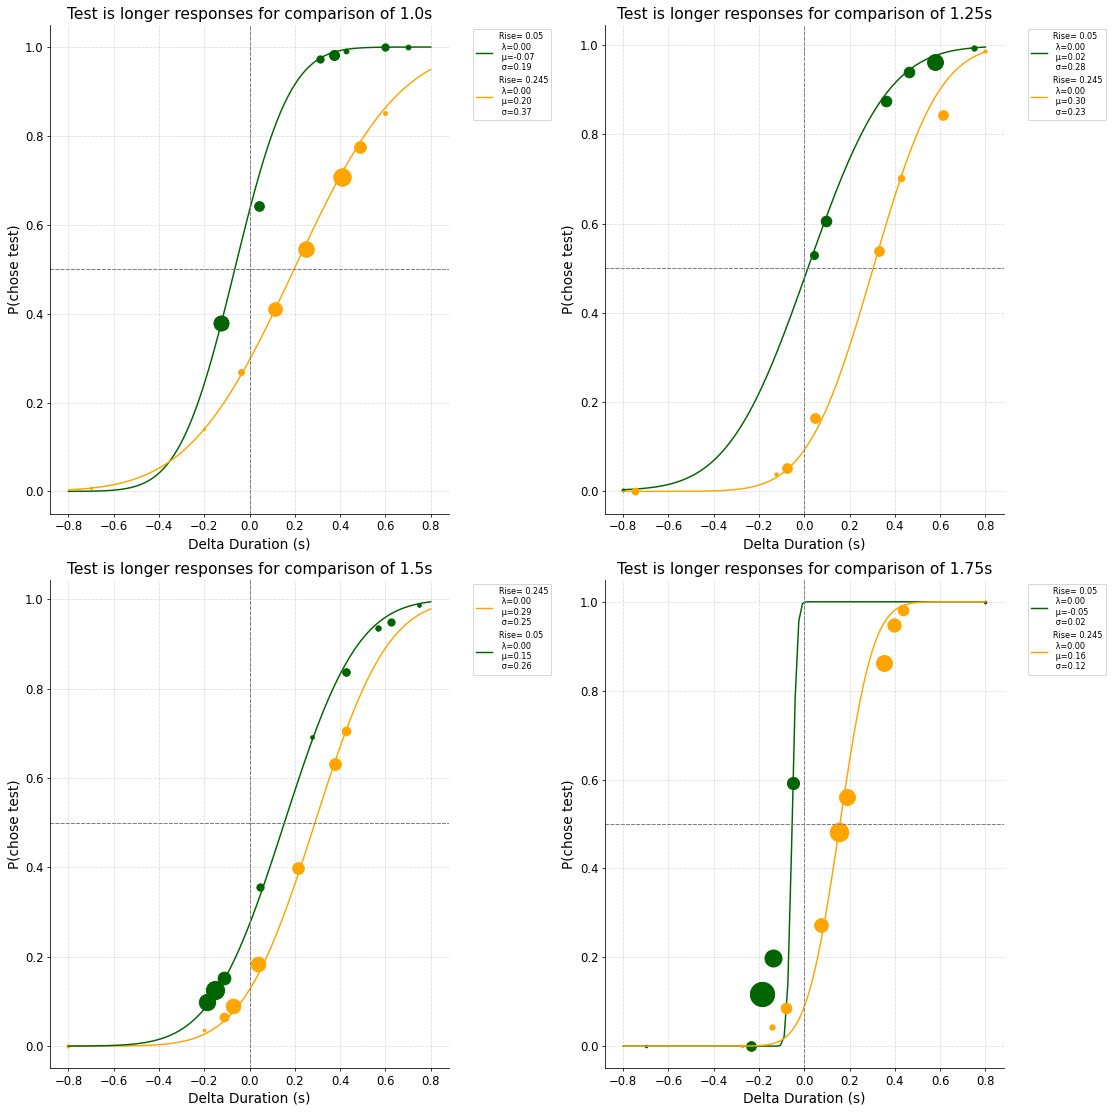

In [ ]:
def pregrouped_plot_psychometric_functions(data):
    fig, axs = plt.subplots(2, 2, figsize=(16, 16))

    for k, i in enumerate(data['standard_dur'].unique()):
        # Filter data by standard duration
        data_by_standard = data[data['standard_dur'] == i].copy()

        # Plot psychometric functions
        for j in data_by_standard['rise_dur'].unique():
            lineStyle = '--' if i == 0.050 else '-'  # Different line style for rise_dur=0.050
            lineColor = 'darkgreen' if j == 0.050 else 'orange'  # Different line color for rise_dur=0.050

            data_by_standard_and_rise = data_by_standard[data_by_standard['rise_dur'] == j]

            # bootstrap Y
            y_bootstrap_fits, y_bootstraps = full_bootstraping(data_by_standard_and_rise, 1000)

            lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(y_bootstraps)
            print(f"For standard dur of {i} and rise duration of {j} λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

            x_data = y_bootstraps['delta_dur_percents']
            y_data = y_bootstraps['p_choose_test']
            total_bins=y_bootstraps['total_responses']            
            # Normalize bin sizes for scatter plot
            ax = axs[k // 2, k % 2]

            for m in np.linspace(min(y_bootstraps['delta_dur_percents']),max(y_bootstraps['delta_dur_percents']),10):
                # search for values +- 0.2 of the i value
                mask=(x_data>=m-0.2) & (x_data<m+0.2)
                # get the mean of the values
                x_mean=np.mean(x_data[mask])
                y_mean=np.mean(y_data[mask])
                # get the total responses
                total_resp=np.sum(total_bins[mask])
                # plot the mean values
                ax.plot(x_mean,y_mean,'o',markersize=total_resp/np.sum(total_bins)*30,color=lineColor)
                

            x_fit = np.linspace(min(data['delta_dur_percents']), max(data['delta_dur_percents']), 100)
            y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)

            ax.plot(x_fit, y_fit, linestyle=lineStyle, label=f'Rise= {j}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}',color=lineColor)
            ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
            ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
            ax.set_xlabel('Delta Duration (s)')
            ax.set_ylabel('P(chose test)')
            ax.set_title(f'Test is longer responses for comparison of {i}s')
            
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
            # remove axspines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
    plt.tight_layout()
    plt.show()

pregrouped_plot_psychometric_functions(grouped)